# Set-up

In [150]:
import os
import sys
import numpy as np
import pandas as pd
import mudata as mu
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

%matplotlib inline

In [368]:
# Path to mudata
path_mdata = "/cellar/users/aklie/data/datasets/paul15/analysis/scenic/2024_05_20/scenic.h5mu"

# Params
layer = "imputed_count"

# Load data

In [369]:
# MuData
mdata = mu.read_h5mu(path_mdata)
mdata

MuData object with n_obs × n_vars = 2671 × 1999
  obs:	'louvain_annot'
  var:	'n_counts', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
  uns:	'grn'
  1 modality
    rna:	2671 x 1999
      obs:	'paul15_clusters', 'n_counts_all', 'n_counts', 'louvain', 'cell_type', 'louvain_annot', 'Lineage_MEP', 'Lineage_GMP', 'Pseudotime_Lineage_MEP', 'Pseudotime_Lineage_GMP', 'Pseudotime'
      var:	'n_counts', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
      uns:	'cell_type_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'log1p', 'louvain', 'louvain_annot_colors', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca'
      obsm:	'X_diffmap', 'X_draw_graph_fa', 'X_pca'
      varm:	'PCs'
      layers:	'imputed_count', 'normalized_count', 'raw_count', 'scaled_imputed_counts'
      obsp:	'connectivities', 'distances'

# GRN selection

In [382]:
# Parameters
pval = 0.001
score = 0
ntop = 2000
layer = None
cluster_key = "cluster"
cluster = "MEP_2"
grn_key = "grn"
min_regulators = 0
min_targets = 0

In [383]:
# Read in grns
grn = mdata.uns[grn_key]
print(f"Initial GRN has {len(grn)} edges")

Initial GRN has 7731 edges


In [384]:
# Choose a cluster of interest (based on cluster column values in standardized outputs)
grn = grn[grn[cluster_key] == cluster]
print(f"GRN for {cluster} has {len(grn)} edges")

GRN for global has 7731 edges


In [385]:
# If pval and score are not None, filter based on these thresholds
if pval is not None:
    grn = grn[grn["pval"] <= pval]
if score is not None:
    grn = grn[np.abs(grn["score"]) >= score]
print(f"GRN after filtering on edge strength has {len(grn)} edges")

GRN after filtering on edge strength has 7731 edges


In [386]:
# Keep only the top ntop regulators if ntop is not None, use abs value of score
if ntop is not None:
    grn["score_abs"] = np.abs(grn["score"])
    grn = grn.sort_values("score_abs", ascending=False)
    grn = grn.head(ntop)
    grn = grn.drop(columns="score_abs")
print(f"GRN after filtering on top regulators has {len(grn)} edges")

GRN after filtering on top regulators has 7731 edges


In [387]:
# Filter out any tfs that regulate fewer than min_targets genes
tfs = grn["tf"].value_counts()
tfs = tfs[tfs > min_targets].index
grn = grn[grn["tf"].isin(tfs)]
print(f"GRN after filtering on minimum number of targets has {len(grn)} edges")

GRN after filtering on minimum number of targets has 7731 edges


In [388]:
# Filter out any genes that are regulated by fewer than min_regulators tfs
genes = grn["gene"].value_counts()
genes = genes[genes >= min_regulators].index
grn = grn[grn["gene"].isin(genes)]
print(f"GRN after filtering on minimum number of regulators has {len(grn)} edges")

GRN after filtering on minimum number of regulators has 7731 edges


# Scale-free topology

In [390]:
from igraph import Graph
import networkx as nx
from sklearn.linear_model import LinearRegression
import mudata


def _compute_scale_free_topology_fit(
    grn: pd.DataFrame,
    source: str = "tf",
    target: str = "gene",
):
    # Make networkx graph
    G = nx.DiGraph()
    G_ = nx.from_pandas_edgelist(grn, source=source, target=target, edge_attr=True)
    G.add_edges_from(G_.edges())

    # Get degree distribution
    df = pd.DataFrame(np.array(G.degree))
    df.columns = ["ind", "degree"]
    df = df.set_index("ind")
    dist = df.degree.value_counts()/df.degree.value_counts().sum()
    dist.index = dist.index.astype(int)

    # Fit power law
    x = np.log(dist.index.values).reshape([-1,1])
    y = np.log(dist.values).reshape([-1,1])
    model = LinearRegression()
    model.fit(x,y)

    # Store degree distribution, model, and R2 in uns["scale_free_topology"]
    output = {
        "degree_distribution": dist,
        "model": model,
        "r2": model.score(x,y)
    }

    return output


def _compute_scale_free_topology_fit_deprecated(
    grn: pd.DataFrame,
    source: str = "tf",
    target: str = "gene",
    score: str = "score",
):

    # Build iGraph
    g = Graph.DataFrame(grn[[source, target]], directed=True, use_vids=False)
    g.es[score] = grn[score].values.copy()

    # Extract degree distribution
    degree_df = pd.DataFrame(g.degree(mode="all"), columns=["degree"])
    dist = degree_df.degree.value_counts()/degree_df.degree.value_counts().sum()
    
    # Fit power law
    x = np.log(dist.index.values).reshape([-1,1])
    y = np.log(dist.values).reshape([-1,1])
    model = LinearRegression()
    model.fit(x,y)

    # Store degree distribution, model, and R2 in uns["scale_free_topology"]
    output = {
        "degree_distribution": dist,
        "model": model,
        "r2": model.score(x,y)
    }

    return output


def _plot_scale_free_topology_fit(
    degree_dist,
    model,
    ax=None
):
    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(8,4))

    # Plot degree (k) vs P(k)
    ax[0].scatter(degree_dist.index.values, degree_dist.values, c="black")
    ax[0].set_title("degree distribution")
    ax[0].set_xlabel("k")
    ax[0].set_ylabel("P(k)")

    # Get log-log scale
    x = np.log(degree_dist.index.values).reshape([-1,1])
    y = np.log(degree_dist.values).reshape([-1,1])

    # For each x value, calculate the predicted y value
    x_ = np.linspace(x.min(), x.max(), 100).reshape([-1,1])
    y_ = model.predict(x_)

    # Plot log-log scale
    ax[1].set_title(f"degree distribution (log scale)\nslope: {model.coef_[0][0] :.4g}, r2: {model.score(x,y) :.4g}")
    ax[1].plot(x_.flatten(), y_.flatten(), c="black", alpha=0.5)
    ax[1].scatter(x.flatten(), y.flatten(), c="black")
    ax[1].set_ylim([y.min()-0.2, y.max()+0.2])
    ax[1].set_xlim([-0.2, x.max()+0.2])
    ax[1].set_xlabel("log k")
    ax[1].set_ylabel("log P(k)")

    # Return figure
    return fig, ax

In [391]:
out = _compute_scale_free_topology_fit(
    grn
)

(<Figure size 800x400 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'degree distribution'}, xlabel='k', ylabel='P(k)'>,
        <AxesSubplot: title={'center': 'degree distribution (log scale)\nslope: -0.9876, r2: 0.6732'}, xlabel='log k', ylabel='log P(k)'>],
       dtype=object))

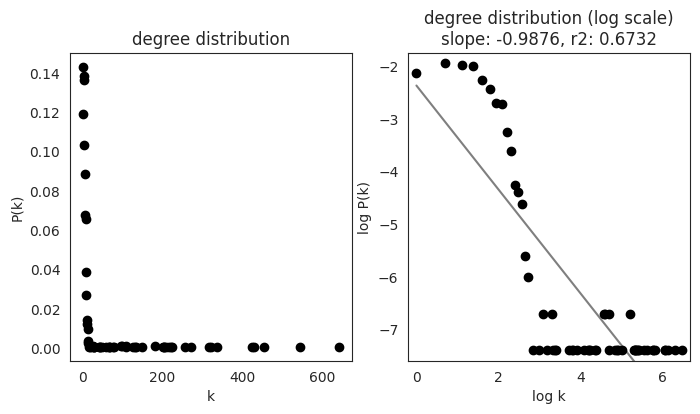

In [392]:
_plot_scale_free_topology_fit(
    out["degree_distribution"],
    out["model"]
)

# Gene expression prediction

In [393]:
# Regression models to choose from
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.svm import LinearSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from joblib import Parallel, delayed
from tqdm.auto import tqdm

In [394]:
def _select_data(
    grn,        
    adata,
    target,
    source_key="tf",
    target_key="gene",
    layer=None,
    return_regulators=False
):
    sub_grn = grn[grn[target_key] == target]
    regulators = sub_grn[source_key].values
    regulator_idx = np.where(adata.var.index.isin(regulators))[0]
    target_idx = np.where(adata.var.index == target)[0]
    if layer is not None:
        if layer not in adata.layers.keys():
            raise ValueError(f"Layer {layer} not found in adata.")
        X = adata[:, regulator_idx].layers[layer].copy()
        y = adata[:, target_idx].layers[layer].copy()
    else:
        X = adata[:, regulator_idx].X.copy()
        y = adata[:, target_idx].X.copy()
    if hasattr(X, "toarray"):
        X = X.toarray()
    if hasattr(y, "toarray"):
        y = y.toarray()
    if len(y.shape) > 1:
        y = y.flatten()
    if return_regulators:
        return X, y, regulators
    else:
        return X, y


def _fit_model(
    grn, 
    adata,
    target,
    model=LinearRegression(),
    min_regulators=1,
    source_key="tf",
    target_key="gene",
    layer=None,
    verbose=True
):
    X, y, regulators = _select_data(grn, adata, target, source_key, target_key, layer, return_regulators=True)
    n_cells, n_regulators = X.shape
    if n_regulators < min_regulators:
        if verbose:
            print(f"Skipping {target} due to insufficient number of regulators: {n_regulators}")
        return None
    model.fit(X, y)
    r2 = model.score(X, y)
    mse = np.mean((model.predict(X) - y) ** 2)
    return {"target": target, "r2": r2, "mse": mse, "n_cells": n_cells, "regulators": regulators}


def _compute_gene_expression_prediction(
    grn,
    adata,
    model=LinearRegression(),
    min_regulators=1,
    source_key="tf",
    target_key="gene",
    layer=None,
    n_jobs=1,
    verbose=True,
):
    """
    Computes the proportion of variance in the data explained by each program.

    ARGS
        mdata : MuData
            mudata object containing anndata of program scores and cell-level metadata.
        grn_key: str
            index for the anndata object (mdata[grn_key]) in the mudata object.
        data_key: str
            index of the genomic data anndata object (mdata[data_key]) in the mudata object.
        model: sklearn.linear_model
            model to fit the gene expression prediction.
        min_regulators: int
            minimum number of regulators required to fit the model.
        n_jobs: int (default: 1)
            number of threads to run processes on.
        verbose: Bool (default: True)
            print progress.
        inplace: Bool (default: True)
            update the mudata object inplace or return a copy
       
    RETURNS 
        if not inplace:
            mdata[grn_key].var['explained_variance_ratio_{}'.format(layer)]
            
    """
    targets = grn[target_key].unique()
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(_fit_model)(
            grn, adata, target, model, min_regulators, source_key, target_key, layer, verbose
        ) for target in tqdm(targets, disable=not verbose,
                             desc="Gene expression prediction", unit="targets")
    )
    
    results = [r for r in results if r is not None]
    results = pd.DataFrame(results)
    results["n_regulators"] = results["regulators"].apply(len)
    
    return results

In [395]:
# Get the RNA anndata
adata = mdata.mod["rna"].copy()
adata

AnnData object with n_obs × n_vars = 2671 × 1999
    obs: 'paul15_clusters', 'n_counts_all', 'n_counts', 'louvain', 'cell_type', 'louvain_annot', 'Lineage_MEP', 'Lineage_GMP', 'Pseudotime_Lineage_MEP', 'Pseudotime_Lineage_GMP', 'Pseudotime'
    var: 'n_counts', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
    uns: 'cell_type_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'log1p', 'louvain', 'louvain_annot_colors', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count', 'scaled_imputed_counts'
    obsp: 'connectivities', 'distances'

In [396]:
if layer in adata.layers:
    print(f"Using data in layer {layer} for regression.")
    adata.X = adata.layers[layer].copy()

In [397]:
gene = "Malat1"

In [398]:
# Test it
X, y = _select_data(grn, adata, gene)
X.shape, y.shape

((2671, 6), (2671,))

In [399]:
# How many regulators are there?
grn[grn["gene"] == gene]

,tf,gene,score,pval,cluster
2508,Gata2,Malat1,1.490482,0.000864,global
5148,Nfe2,Malat1,1.228244,0.016693,global
3472,Irf1,Malat1,0.879550,0.000064,global
1611,Fli1,Malat1,0.839920,0.024846,global
5580,Nr3c1,Malat1,0.746405,0.005500,global
6181,Sox4,Malat1,0.467780,0.166318,global


In [400]:
_fit_model(
    grn=grn,
    adata=adata,
    target=gene,
    model=XGBRegressor(),
    min_regulators=5,
    verbose=True
)

{'target': 'Malat1',
 'r2': 0.5210618220390228,
 'mse': 0.28148627,
 'n_cells': 2671,
 'regulators': array(['Gata2', 'Nfe2', 'Irf1', 'Fli1', 'Nr3c1', 'Sox4'], dtype=object)}

In [401]:
fit_df = _compute_gene_expression_prediction(
    grn,
    adata,
    model=Ridge(alpha=10),
    min_regulators=3,
    n_jobs=3,
    verbose=True
)

Gene expression prediction:   0%|          | 0/1628 [00:00<?, ?targets/s]

Skipping Tmem176b due to insufficient number of regulators: 2
Skipping Abcb4 due to insufficient number of regulators: 2
Skipping Tsc22d4 due to insufficient number of regulators: 1
Skipping Lsm4 due to insufficient number of regulators: 2
Skipping Nkg7 due to insufficient number of regulators: 1
Skipping Treml2 due to insufficient number of regulators: 2
Skipping Ass1 due to insufficient number of regulators: 1
Skipping Cd9 due to insufficient number of regulators: 1
Skipping Ppm1g due to insufficient number of regulators: 2
Skipping Imp4 due to insufficient number of regulators: 2
Skipping Cxxc1 due to insufficient number of regulators: 1
Skipping Irf7 due to insufficient number of regulators: 1
Skipping Ndufa10 due to insufficient number of regulators: 2
Skipping Prpf4b due to insufficient number of regulators: 2
Skipping Cdc34 due to insufficient number of regulators: 1
Skipping Psme1 due to insufficient number of regulators: 1
Skipping Dctn5 due to insufficient number of regulator

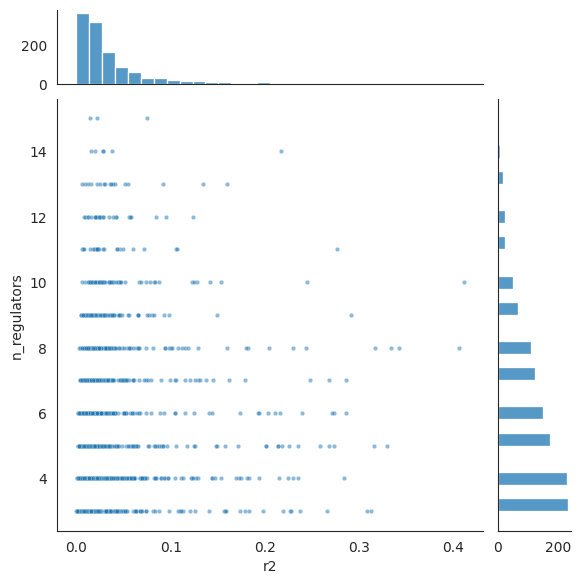

In [402]:
# Plot a joint plot of R^2 vs number of regulators colored by mse
sns.jointplot(
    data=fit_df,
    x="r2",
    y="n_regulators",
    kind="scatter",
    marginal_kws=dict(bins=30, fill=True),
    marginal_ticks=True,
    s=10,
    alpha=0.5,
)

In [403]:
# Look at top 10 r2
fit_df.sort_values("r2", ascending=False).head(10)

,target,r2,mse,n_cells,regulators,n_regulators
100,H2afy,0.410913,0.556442,2671,"[Gata1, Irf8, Spi1, Cebpa, Sox4, Etv6, Gata2, ...",10
184,Coro1a,0.406301,0.449895,2671,"[Gata1, Irf8, Spi1, Cebpa, Sox4, Etv6, Irf1, G...",8
13,Emb,0.342672,0.229549,2671,"[Irf8, Spi1, Gata1, Klf4, Cebpa, Gata2, Stat5a...",8
136,Laptm5,0.333934,0.443527,2671,"[Gata1, Gfi1b, Irf8, Nfia, Spi1, Runx1, Cebpa,...",8
362,Aqp1,0.329112,0.315534,2671,"[Gata1, Gfi1b, Spi1, Cebpa, Irf1]",5
227,Zfpm1,0.316596,0.355158,2671,"[Gata1, Spi1, Gfi1b, Cebpa, Irf2, Egr1, Stat1,...",8
11,Tyrobp,0.315660,0.258587,2671,"[Irf8, Klf4, Spi1, Cebpa, Fli1]",5
153,Fam132a,0.312603,0.545836,2671,"[Gfi1b, Gata1, Fli1]",3
30,Lgals1,0.308400,0.558927,2671,"[Irf8, Gata1, Spi1]",3
345,Ramp1,0.291196,0.358620,2671,"[Gata1, Gfi1b, Spi1, Irf8, Cebpa, Stat5a, Sox4...",9


Skipping Leprot due to insufficient number of regulators: 2
Skipping Tmem50a due to insufficient number of regulators: 1
Skipping Tecr due to insufficient number of regulators: 2
Skipping Hagh due to insufficient number of regulators: 1
Skipping Clspn due to insufficient number of regulators: 1
Skipping Pglyrp2 due to insufficient number of regulators: 2
Skipping Ndufb9 due to insufficient number of regulators: 1
Skipping Snrpb due to insufficient number of regulators: 2
Skipping Psmb3 due to insufficient number of regulators: 1
Skipping Ncbp1 due to insufficient number of regulators: 1
Skipping Smpd4 due to insufficient number of regulators: 2
Skipping Ddx24 due to insufficient number of regulators: 2
Skipping Batf3 due to insufficient number of regulators: 2
Skipping Dctpp1 due to insufficient number of regulators: 2
Skipping Fth1 due to insufficient number of regulators: 2
Skipping Pycard due to insufficient number of regulators: 1
Skipping Dcaf8 due to insufficient number of regula

# DONE!

---